In [1]:
import torch
from torch import nn

## 编解码

### 编码器

In [2]:
class Encoder(nn.Module):
    """编码器-解码器结构的基本编码器接口。"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

### 解码器

&emsp;&emsp;在下面的解码器接口中，我们新增一个`init_state`函数用于将编码器的输出（`enc_outputs`）转换为编码后的状态。

In [3]:
class Decoder(nn.Module):
    """编码器-解码器结构的基本解码器接口。"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

### 合并编码器和解码器

&emsp;&emsp;最后，“编码器-解码器”结构包含了一个编码器和一个解码器，并且还拥有可选的额外的参数。在前向传播中，编码器的输出用于生成编码状态，这个状态又被解码器作为其输入的一部分。

In [4]:
class EncoderDecoder(nn.Module):
    """编码器-解码器结构的基类。"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

## Seq2seq

In [5]:
import sys
sys.path.append("..")
from d2l import torch as d2l

### 编码器

&emsp;&emsp;这里我们采用一层嵌入层(`embedding layer`)来获得输入序列中每个词元的特征向量。

In [6]:
class Seq2SeqEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层，将vocab_size编码为embed_size。
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
        
    def forward(self, X, *args):
        X = self.embedding(X)  # 输出的‘X’的形状：（batch_size, num_steps, embed_size）
        
        X = X.permute(1, 0, 2) # 在循环神经网络中，默认的是第一个轴对应时间步。
        
        output, state = self.rnn(X)
        # `output`的形状: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state[0]`的形状: (`num_layers`, `batch_size`, `num_hiddens`)
        
        return output, state

### 解码器

&emsp;&emsp;实现解码器时，我们可以直接使用编码器最后一个时间步的隐藏状态来初始化解码器的隐藏状态。

&emsp;&emsp;如果编解码器是使用循环神经网络实现的话，我们就需要**编码器和解码器具有相同数量的层和隐藏单元**。

&emsp;&emsp;为了进一步包含经过编码的输入序列的信息，上下文变量在所有时间步与解码器的输入进行拼接(`concatenate`)。

In [7]:
class Seq2SeqDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        # 嵌入层，将vocab_size编码为embed_size。
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        # GRU的每个时间步的输入大小为：embed_size + num_hiddens。
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, *args):
        """
        enc_outputs为(output, state)
        """
        return enc_outputs[1]
    
    def forward(self, X, state):
        """
        X: shape = (`batch_size`, `num_steps`, `embed_size`)
        state: shape = (num_layers, batch_size, num_hiddens)
        """

        # 输出'X'的形状：(`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        
        # 输出'X'的形状：(`num_steps`, `batch_size`, `embed_size`)
        X = X.permute(1, 0, 2) # 在循环神经网络中，默认的是第一个轴对应时间步。
        
        # 广播‘context’, 使其具有与‘X’相同的‘num_steps’。
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2) # shape = (num_steps, batch_size, num_hiddens)
        
        output, state = self.rnn(X_and_context, state)
        # `output`的形状: (`num_steps`, `batch_size`, `num_hiddens`)
        # print(output.size())
        output = self.dense(output)# .permute(1, 0, 2)
        # `output`的形状: (`num_steps`, `batch_size`, `vocab_size`)
        
        output = output.permute(1, 0, 2)
        # `output`的形状: (`batch_size`, `num_steps`, `vocab_size`)
        
        # `state[0]`的形状: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

### 损失函数

&emsp;&emsp;在每个时间步，解码器预测了输出词元的概率分布。

&emsp;&emsp;类似于语言模型，可以使用softmax来获得分布，并通过计算交叉熵损失函数来进行优化。

&emsp;&emsp;特定的填充词元被添加到序列的末尾，因此不同长度的序列可以以相同形状的小批量加载。但是，应该将填充词元的预测排除在损失函数的计算之外。为此，我们可以使用seqence_mask函数，通过**零值化**屏蔽不相关的项，以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。

#### 序列化Mask

In [8]:
def sequence_mask(X, valid_len, value=0):
    """
    # 在序列中屏蔽不相关的项。
    """
    maxlen = X.size(1)
    
    # arange生成下标，然后没行下标小于valid_len中的值为True。
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    
    # 取反之后赋值为0。
    X[~mask] = value
    return X

In [9]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

&emsp;&emsp;我们还可以使用此函数屏蔽最后几个轴上的所有项。如果愿意，也可以使用指定的非零值来替换这些项。

In [10]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value = -1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

#### 带Masked的SoftMax

&emsp;&emsp;我们可以扩展softmax交叉熵损失函数来遮蔽不相关的预测。最初所有预测词元的掩码都设置为1。一旦给定了有效长度，与填充词云对应的掩码将被设置为0。最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。

In [11]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """
    带mask的softmax交叉熵损失函数。
    """
    # pred 的形状：（batch_size, num_steps, vocab_size）
    # label 的形状：（batch_size, num_steps）
    # valid_len 的形状：（batch_size）
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        
        weighted_loss = (unweighted_loss * weights).mean(dim = 1)
        return weighted_loss

&emsp;&emsp;我们可以创建三个相同的序列来进行代码健全性检查，然后分别指定这些序列的有效长度为  4 、 2  和  0 。结果就是，第一个序列的损失应为第二个序列的两倍，而第三个序列的损失应为零。

In [12]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

## 训练

In [13]:
batch_size, num_steps = 64, 10
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

In [14]:
encoder = Seq2SeqEncoder(vocab_size = len(src_vocab), 
                         embed_size = 32, 
                         num_hiddens = 32, 
                         num_layers = 2, 
                         dropout=0.1)

decoder = Seq2SeqDecoder(vocab_size = len(tgt_vocab),
                         embed_size = 32, 
                         num_hiddens = 32, 
                         num_layers = 2,
                         dropout=0.1)

def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def xavier_init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.GRU:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])


lr = 0.005
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = EncoderDecoder(encoder, decoder)
net.apply(xavier_init_weights)
net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=lr)

loss = MaskedSoftmaxCELoss()
net.train()

loss_list = []
for epoch in range(300):
    for batch in train_iter:
        X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
        
        # decoder的输入，需要给定一个输入，然后预测下一个词汇。第一个输入是'<bos>', 之后的输入都需要后移。
        bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
        
        dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 教师强制
        
        Y_hat, _ = net(X, dec_input, X_valid_len)
        
        optimizer.zero_grad()
        l = loss(Y_hat, Y, Y_valid_len)
        l.sum().backward()
        grad_clipping(net, 1)
        num_tokens = Y_valid_len.sum()
        optimizer.step()
        
        with torch.no_grad():
            loss_list.append(l.sum().item())

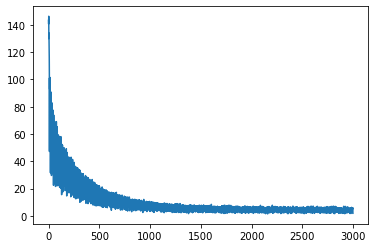

In [15]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.show()

## 预测

&emsp;&emsp;为了采用一个接着一个词元的方式预测出序列，每个解码器当前时间步的输入都将来自于前一时间步的预测词元。

&emsp;&emsp;与训练类似，序列开始词元("\<bos>")在初始时间步被输入到解码器中。当输出序列的预测遇到序列结束词元('\<eoc>')时，预测就结束了。

In [16]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, device, save_attention_weights=False):
    """序列到序列的模型预测"""
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    
    # 添加批量轴
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入。
        dec_X = Y.argmax(dim = 2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        
        if pred == tgt_vocab['<eos>']:
            break
        
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

## 预测序列的评估

&emsp;&emsp;用$p_{n}$表示$n$元语法的精确度，它是两个数量的比值:

1. 第一个是预测序列与标签序列中匹配的$n$元语法的数量。

2. 第二个是预测序列中$n$元语法的数量的比率。

&emsp;&emsp;详细解释为：即给定的标签序列$A、B、C、D、E、F$和预测序列$A、B、B、C、D$，我们有$p_{1} = \frac{4}{5}, p_{2} = \frac{3}{4}, p_{3} = \frac{1}{3}$和$p_{4} = 0$。另外，$len_{label}$表示标签序列中的词元数和$len_{pre}$表示预测序列中的词元数。那么，$BLEU$的定义是：

$$
\exp \left(\min \left(0,1-\frac{\text { len }_{\text {label }}}{\text { len }_{\text {pred }}}\right)\right) \prod_{n=1}^{k} p_{n}^{1 / 2^{n}}
$$

&emsp;&emsp;其中$k$是用于匹配的最长的$n$元语法。

&emsp;&emsp;当预测序列与标签序列完全相同时，`BLEU`为`1`。

1. 此外，由于n元语法越长则匹配难度越大，所以BLEU为更长的n元语法的精确度分配更大的权重。具体来说，当$p_{n}$固定时，$p_{n}^{\frac{1}{2^{n}}}$会随着$n$的增长而增加(原始论文使用$p_{n}^{\frac{1}{n}}$)。

2. 而且，由于预测的序列越短获得的$p_{n}$值越高，所以乘法项之前的系数用于惩罚较短的预测序列。例如，当$k = 2$时，给定标签序列$A、B、C、D、E、F$和预测序列$A、B$，尽管$p_{1} = p_{2} = 1$, 惩罚因子$exp(1 - 6/2) \sim 0.14$会降低BLEU。

In [17]:
import math
import collections
# 计算 BLEU
def bleu(pred_seq, label_seq, k):
    """
    
    """
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    
    score = math.exp(min(0, 1 - len_label / len_pred))
    # 遍历不同的n-gram。
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):  # 遍历label中的n-gram语法。
            label_subs[''.join(label_tokens[i: i + n])] += 1
            
        for i in range(len_pred - n + 1):  # 遍历预测中的n-gram语法。
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1 # 如果发现有，则匹配的数字需要加1。
                label_subs[''.join(pred_tokens[i: i + n])] -= 1  # label中的数字需要减去1。
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [18]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai du <unk> pas ?, bleu 0.000
he's calm . => il est mouillé <unk> tomber tomber . ! !, bleu 0.343
i'm home . => je suis juste !, bleu 0.418
